Analyze the survey results sent out 4Q25 to broader membership

In [20]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
os.getcwd()

'/home/candela/pCloudDrive/pCloud Backup/mofongo-HP-EliteBook-840-G8-Notebook-PC/Documents/ghfc/board_material/greeneHill/surveyResults'

In [6]:
os.listdir()

['2025_skills', 'surveyResults_25.ipynb', 'resources.txt', 'copilot_plan.md']

In [7]:
survey = pd.read_csv('./2025_skills/2025 Membership Survey .csv')

In [8]:
survey.describe()

,Timestamp,Username,Name,What portion of your grocery shopping is done at the co-op?,What are your top 3 categories when you shop at the co-op?,Would any of the below motivate you to get more involved with the co-op?,What if anything would cause you to leave the co-op?,What skills do you have that the co-op can contact you about in case of special projects?,Unnamed: 8
count,99,99,87,99,99,73,97,71,17
unique,99,99,87,6,36,28,31,39,17
top,2025/12/08 6:59:49 PM EST,hellojungjoo@gmail.com,Jarrett DePasquale,Almost all,Produce;Bulk;Dairy,More opportunities for in-person engagement (e...,My proximity to the co-op changes,Writing/Editing,nellymcc13@gmail.com
freq,1,1,1,28,16,13,22,15,1


In [4]:
survey.dtypes

Timestamp                                                                                    object
Username                                                                                     object
Name                                                                                         object
What portion of your grocery shopping is done at the co-op?                                  object
What are your top 3 categories when you shop at the co-op?                                   object
Would any of the below motivate you to get more involved with the co-op?                     object
What if anything would cause you to leave the co-op?                                         object
What skills do you have that the co-op can contact you about in case of special projects?    object
Unnamed: 8                                                                                   object
dtype: object

In [5]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column                                                                                     Non-Null Count  Dtype 
---  ------                                                                                     --------------  ----- 
 0   Timestamp                                                                                  99 non-null     object
 1   Username                                                                                   99 non-null     object
 2   Name                                                                                       87 non-null     object
 3   What portion of your grocery shopping is done at the co-op?                                99 non-null     object
 4   What are your top 3 categories when you shop at the co-op?                                 99 non-null     object
 5   Would any of the below motivate you to get more involved wit

In [9]:
survey2 = survey.assign(
            shop_portion = survey['What portion of your grocery shopping is done at the co-op?'],
              shop_cats = survey['What are your top 3 categories when you shop at the co-op?'],
              involvement = survey['Would any of the below motivate you to get more involved with the co-op?'],
              leave_coop = survey['What if anything would cause you to leave the co-op?'],
              skills = survey['What skills do you have that the co-op can contact you about in case of special projects?'])

In [14]:
#look at the unique values of column 'leave_coop'
isinstance(survey2['leave_coop'].str.split(';',expand = False),pd.Series)

True

In [10]:
leave_coop_col = survey2['leave_coop'].str.split(';',expand = False)

In [11]:
#explode here creates a new row for each list item in each element of the Series
#this creates a list of unique, non NA values from the original leave_coop column
unq_leave_coop = leave_coop_col.explode().dropna().drop_duplicates().sort_values().to_list()

In [84]:
#this variable isn't used beyond this view
unq_leave_coop

['Disorganization (shift tasks unclear or redundant, food waste)',
 'I am unable to meet the work requirement',
 "I'd probably try to stick around",
 'Lack of selection',
 'My proximity to the co-op changes',
 'Persistent issue of fruit flies, moths, etc.',
 'Price increases',
 'Shopping hours are limited',
 "The co-op's mission, model, or management changes",
 "negative experiences with the co-op's policies & workplace culture  "]

Will try to create categorical values from these (range of the length of unique list), then assign values to a unique columns of a dataframe, from which I can draw a heatmap and correlation matrix. The correlation matrix will be a 10x10 matrix (length of the list). I'll need to make a sparse matrix for each respondent

In [ ]:
#ensure that the index is persisted post explosion
leave_coop_col.explode()[0:7]

0           My proximity to the co-op changes
0    I am unable to meet the work requirement
0                             Price increases
0                           Lack of selection
1           My proximity to the co-op changes
1                           Lack of selection
2           My proximity to the co-op changes
Name: leave_coop, dtype: object

In [ ]:
#laying down groundwork for the dummy matrix
expl_ser = leave_coop_col.explode()
expl_ser_dum = pd.get_dummies(expl_ser, dummy_na=True, dtype='int')

In [44]:
#apparent that the exploded values need to be consolidated on the index
#unq_ix = list(set(expl_ser_dum.index))
new_df = expl_ser_dum.groupby(level=0).sum()

Sum across columns to measure the frequency of each response

In [76]:
new_df.sum(axis=0).sort_values(ascending=False)

My proximity to the co-op changes                                       70
The co-op's mission, model, or management changes                       31
Price increases                                                         30
I am unable to meet the work requirement                                28
Lack of selection                                                       25
NaN                                                                      2
Disorganization (shift tasks unclear or redundant, food waste)           1
I'd probably try to stick around                                         1
Persistent issue of fruit flies, moths, etc.                             1
Shopping hours are limited                                               1
negative experiences with the co-op's policies & workplace culture       1
dtype: int64

*GOTCHA* I try a matrix multiply two ways. They're both equivalent. I was initially confused when the off-diagonal sum was greater than the diagnoal, but then I learned that the diagonal value could only the be the total unique responders that selected that value; however they were not limited to choosing many other choices, so each response could end up with a 1:n ratio (n = the total amount of other responses chosen)

In [82]:
heat_df = np.transpose(new_df) @ new_df.to_numpy() #this doesn't work
heat_df.columns = heat_df.index
print(heat_df.shape)

xy = np.dot(np.transpose(new_df),new_df.to_numpy())
print(xy.shape)

(11, 11)
(11, 11)


In [66]:
#collect some stats
heat_mat = heat_df.to_numpy()
test = pd.Series(heat_mat.diagonal())
test.index = heat_df.index
print(test.sort_values(ascending=False))

My proximity to the co-op changes                                       70
The co-op's mission, model, or management changes                       31
Price increases                                                         30
I am unable to meet the work requirement                                28
Lack of selection                                                       25
NaN                                                                      2
Disorganization (shift tasks unclear or redundant, food waste)           1
I'd probably try to stick around                                         1
Persistent issue of fruit flies, moths, etc.                             1
Shopping hours are limited                                               1
negative experiences with the co-op's policies & workplace culture       1
dtype: int64


Count the off-diagnoal responses; could serve as a proxy for elasticity/inelasticity

In [70]:
np.fill_diagonal(heat_mat, 0)
sum_array = heat_mat.sum(axis=1)
test = pd.Series(sum_array)
test.index = heat_df.index
print(test.sort_values(ascending=False))

My proximity to the co-op changes                                       76
The co-op's mission, model, or management changes                       50
Price increases                                                         48
I am unable to meet the work requirement                                43
Lack of selection                                                       40
negative experiences with the co-op's policies & workplace culture       4
Persistent issue of fruit flies, moths, etc.                             3
I'd probably try to stick around                                         1
Disorganization (shift tasks unclear or redundant, food waste)           1
Shopping hours are limited                                               0
NaN                                                                      0
dtype: int64


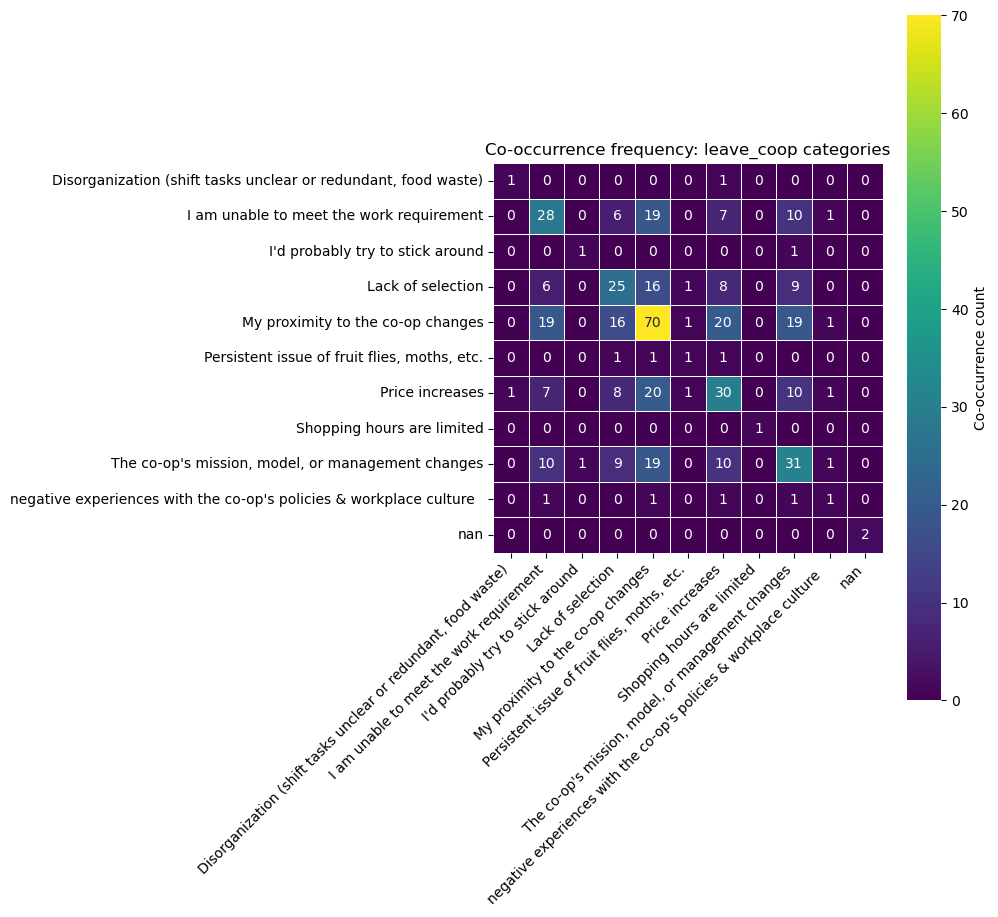

In [56]:
plt.figure(figsize=(10, 10))
sns.heatmap(heat_df, cmap='viridis', annot=True, fmt='d', linewidths=.5,
            cbar_kws={'label': 'Co-occurrence count'}, square=True)
plt.title('Co-occurrence frequency: leave_coop categories')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()